In [1]:
import numpy as np
import matplotlib.pylab as plt
from tempfile import NamedTemporaryFile
from IPython.display import HTML
from matplotlib import animation

In [48]:
x = np.linspace(0,1,51)

# Smooth Rectangle
f = 1. / (1. + np.exp(80.*(np.abs(x-0.5) - 0.15)))

# Triangle
#f = np.zeros((51))
#for i in range(13,26):
#    f[i] = (4.)*(x[i]-0.25)
#for i in range(26,38):
#    f[i] = (-4.)*(x[i]-0.75)


exact_f = np.empty((251,51))
f2 = f
exact_f[0,:] = f2
for i in range(1,251):
    if (i%5 == 0):
        f2 = np.roll(f2,2)
    if ((i+50)%125 == 0):
        f2 = np.roll(f2,1)
    exact_f[i,:] = f2

In [59]:
# Fourth Order Spatial, RK3 in Time
cnum = 0.4
gamma = 0.025

qc4 = np.empty((251,51))
rk3_1 = np.empty((251,51))
rk3_2 = np.empty((251,51))
qc4[0,:] = f
rk3_1[0,:] = 0
rk3_2[0,:] = 0
    
for i in range(1,251):
    # First RK3 Step
    rk3_1[i,0] = qc4[i-1,0] - cnum/3.*(8.*(qc4[i-1,1]-qc4[i-1,49]) - qc4[i-1,2] + qc4[i-1,48])/12.
    rk3_1[i,1] = qc4[i-1,1] - cnum/3.*(8.*(qc4[i-1,2]-qc4[i-1,0]) - qc4[i-1,3] + qc4[i-1,49])/12.
    for j in range(2,49):
        rk3_1[i,j] = qc4[i-1,j] - cnum/3.*(8.*(qc4[i-1,j+1]-qc4[i-1,j-1]) - qc4[i-1,j+2] + qc4[i-1,j-2])/12.

    # BCs
    rk3_1[i,49] = qc4[i-1,49] - cnum/3.*(8.*(qc4[i-1,0]-qc4[i-1,48]) - qc4[i-1,1] + qc4[i-1,47])/12.
    rk3_1[i,50] = rk3_1[i,0]
    
    # Second RK3 Step
    rk3_2[i,0] = qc4[i-1,0] - cnum/2.*(8.*(rk3_1[i,1]-rk3_1[i,49]) - rk3_1[i,2] + rk3_1[i,48])/12.
    rk3_2[i,1] = qc4[i-1,1] - cnum/2.*(8.*(rk3_1[i,2]-rk3_1[i,0]) - rk3_1[i,3] + rk3_1[i,49])/12.
    for j in range(2,49):
        rk3_2[i,j] = qc4[i-1,j] - cnum/2.*(8.*(rk3_1[i,j+1]-rk3_1[i,j-1]) - rk3_1[i,j+2] + rk3_1[i,j-2])/12.

    # BCs
    rk3_2[i,49] = qc4[i-1,49] - cnum/2.*(8.*(rk3_1[i,0]-rk3_1[i,48]) - rk3_1[i,1] + rk3_1[i,47])/12.
    rk3_2[i,50] = rk3_2[i,0]
    
    # Third RK3 Step
    qc4[i,0] = qc4[i-1,0] - cnum*(8.*(rk3_2[i,1]-rk3_2[i,49]) - rk3_2[i,2] + rk3_2[i,48])/12.
    qc4[i,1] = qc4[i-1,1] - cnum*(8.*(rk3_2[i,2]-rk3_2[i,0]) - rk3_2[i,3] + rk3_2[i,49])/12.
    for j in range(2,49):
        qc4[i,j] = qc4[i-1,j] - cnum*(8.*(rk3_2[i,j+1]-rk3_2[i,j-1]) - rk3_2[i,j+2] + rk3_2[i,j-2])/12.

    # BCs
    qc4[i,49] = qc4[i-1,49] - cnum*(8.*(rk3_2[i,0]-rk3_2[i,48]) - rk3_2[i,1] + rk3_2[i,47])/12.
    qc4[i,50] = qc4[i,0]

TRER = np.sqrt(np.sum((f - qc4[250,:])**2./50.))
print TRER

0.0682446156277


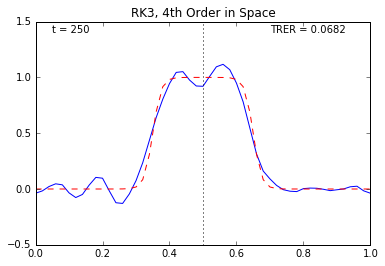

In [60]:
%matplotlib inline
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20,dpi=150,extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.5, 1.5))
plt.title('RK3, 4th Order in Space')
line, = ax.plot([], [], lw=1)
line2, = ax.plot([], [], lw=1,ls='dashed',color='r')
time_template = 't = %.0f'
time_text = ax.text(0.05, 1.4, '')
ax.axvline(0.5,ls='dotted',color='k')
plt.text(0.7,1.4,'TRER = '+str(np.round(TRER,decimals=4)))
x2 = x

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    time_text.set_text('')
    return line, line2, time_text

# animation function.  This is called sequentially
def animate(i):
    #x = np.linspace(0, 2, 1000)
    #y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, qc4[i,:])
    line2.set_data(x, exact_f[i,:])
    time_text.set_text(time_template % (i))
    return line, line2, time_text

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=251, interval=20, blit=True)

# call our new function to display the animation
#display_animation(anim)

# To same animation, comment out previous line and
# uncomment the next two lines.
fname = 'rk3_time_4th_order_space_box.mp4'
anim.save(fname, fps=20,dpi=500)

In [61]:
# Sixth Order Spatial, RK3
cnum = 0.4
gamma = 0.025

qc6 = np.empty((251,51))
rk3_1 = np.empty((251,51))
rk3_2 = np.empty((251,51))
qc6[0,:] = f
rk3_1[0,:] = 0
rk3_2[0,:] = 0


for i in range(1,251):
    # First RK3 Step
    rk3_1[i,0] = qc6[i-1,0] - cnum/3.*(45.*(qc6[i-1,1]-qc6[i-1,49]) + 9.*(qc6[i-1,48] - qc6[i-1,2]) 
                                   + qc6[i-1,3] - qc6[i-1,47])/60.
    rk3_1[i,1] = qc6[i-1,1] - cnum/3.*(45.*(qc6[i-1,2]-qc6[i-1,0]) + 9.*(qc6[i-1,49] - qc6[i-1,3]) 
                                   + qc6[i-1,4] - qc6[i-1,48])/60.
    rk3_1[i,2] = qc6[i-1,2] - cnum/3.*(45.*(qc6[i-1,3]-qc6[i-1,1]) + 9.*(qc6[i-1,0] - qc6[i-1,4]) 
                                   + qc6[i-1,5] - qc6[i-1,49])/60.
    
    for j in range(3,48):
        rk3_1[i,j] = qc6[i-1,j] - cnum/3.*(45.*(qc6[i-1,j+1]-qc6[i-1,j-1]) + 9.*(qc6[i-1,j-2] - qc6[i-1,j+2]) 
                                       + qc6[i-1,j+3] - qc6[i-1,j-3])/60.
    # BCs
    rk3_1[i,48] = qc6[i-1,48] - cnum/3.*(45.*(qc6[i-1,49]-qc6[i-1,47]) + 9.*(qc6[i-1,46] - qc6[i-1,0])
                                     + qc6[i-1,1] - qc6[i-1,45])/60.
    rk3_1[i,49] = qc6[i-1,49] - cnum/3.*(45.*(qc6[i-1,0]-qc6[i-1,48]) + 9.*(qc6[i-1,47] - qc6[i-1,1])
                                     + qc6[i-1,2] - qc6[i-1,46])/60.
    rk3_1[i,50] = rk3_1[i,0]
    
    
    # Second RK3 Step
    rk3_2[i,0] = qc6[i-1,0] - cnum/2.*(45.*(rk3_1[i,1]-rk3_1[i,49]) + 9.*(rk3_1[i,48] - rk3_1[i,2]) 
                                   + rk3_1[i,3] - rk3_1[i,47])/60.
    rk3_2[i,1] = qc6[i-1,1] - cnum/2.*(45.*(rk3_1[i,2]-rk3_1[i,0]) + 9.*(rk3_1[i,49] - rk3_1[i,3]) 
                                   + rk3_1[i,4] - rk3_1[i,48])/60.
    rk3_2[i,2] = qc6[i-1,2] - cnum/2.*(45.*(rk3_1[i,3]-rk3_1[i,1]) + 9.*(rk3_1[i,0] - rk3_1[i,4]) 
                                   + rk3_1[i,5] - rk3_1[i,49])/60.
    
    for j in range(3,48):
        rk3_2[i,j] = qc6[i-1,j] - cnum/2.*(45.*(rk3_1[i,j+1]-rk3_1[i,j-1]) + 9.*(rk3_1[i,j-2] - rk3_1[i,j+2]) 
                                       + rk3_1[i,j+3] - rk3_1[i,j-3])/60.
    # BCs
    rk3_2[i,48] = qc6[i-1,48] - cnum/2.*(45.*(rk3_1[i,49]-rk3_1[i,47]) + 9.*(rk3_1[i,46] - rk3_1[i,0])
                                     + rk3_1[i,1] - rk3_1[i,45])/60.
    rk3_2[i,49] = qc6[i-1,49] - cnum/2.*(45.*(rk3_1[i,0]-rk3_1[i,48]) + 9.*(rk3_1[i,47] - rk3_1[i,1])
                                     + rk3_1[i,2] - rk3_1[i,46])/60.
    rk3_2[i,50] = rk3_2[i,0]
    
    
    # Third RK3 Step
    qc6[i,0] = qc6[i-1,0] - cnum*(45.*(rk3_2[i,1]-rk3_2[i,49]) + 9.*(rk3_2[i,48] - rk3_2[i,2]) 
                                   + rk3_2[i,3] - rk3_2[i,47])/60.
    qc6[i,1] = qc6[i-1,1] - cnum*(45.*(rk3_2[i,2]-rk3_2[i,0]) + 9.*(rk3_2[i,49] - rk3_2[i,3]) 
                                   + rk3_2[i,4] - rk3_2[i,48])/60.
    qc6[i,2] = qc6[i-1,2] - cnum*(45.*(rk3_2[i,3]-rk3_2[i,1]) + 9.*(rk3_2[i,0] - rk3_2[i,4]) 
                                   + rk3_2[i,5] - rk3_2[i,49])/60.
    
    for j in range(3,48):
        qc6[i,j] = qc6[i-1,j] - cnum*(45.*(rk3_2[i,j+1]-rk3_2[i,j-1]) + 9.*(rk3_2[i,j-2] - rk3_2[i,j+2]) 
                                       + rk3_2[i,j+3] - rk3_2[i,j-3])/60.
    # BCs
    qc6[i,48] = qc6[i-1,48] - cnum*(45.*(rk3_2[i,49]-rk3_2[i,47]) + 9.*(rk3_2[i,46] - rk3_2[i,0])
                                     + rk3_2[i,1] - rk3_2[i,45])/60.
    qc6[i,49] = qc6[i-1,49] - cnum*(45.*(rk3_2[i,0]-rk3_2[i,48]) + 9.*(rk3_2[i,47] - rk3_2[i,1])
                                     + rk3_2[i,2] - rk3_2[i,46])/60.
    qc6[i,50] = qc6[i,0] 
TRER = np.sqrt(np.sum((f - qc6[250,:])**2./50.))
print TRER

0.0323606135233


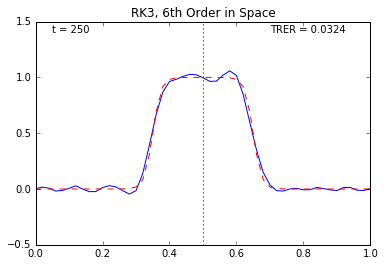

In [62]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.5, 1.5))
plt.title('RK3, 6th Order in Space')
line, = ax.plot([], [], lw=1)
line2, = ax.plot([], [], lw=1,ls='dashed',color='r')
time_template = 't = %.0f'
time_text = ax.text(0.05, 1.4, '')
ax.axvline(0.5,ls='dotted',color='k')
plt.text(0.7,1.4,'TRER = '+str(np.round(TRER,decimals=4)))
x2 = x

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    time_text.set_text('')
    return line, line2, time_text

# animation function.  This is called sequentially
def animate(i):
    #x = np.linspace(0, 2, 1000)
    #y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, qc6[i,:])
    line2.set_data(x, exact_f[i,:])
    time_text.set_text(time_template % (i))
    return line, line2, time_text

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=251, interval=20, blit=True)

# call our new function to display the animation
#display_animation(anim)

# To same animation, comment out previous line and
# uncomment the next two lines.
fname = 'rk3_time_6th_order_space_box.mp4'
anim.save(fname, fps=20,dpi=500)

In [53]:
# Fifth Order Spatial, RK3
cnum = 0.4
gamma = 0.025

qc5 = np.empty((251,51))
rk3_1 = np.empty((251,51))
rk3_2 = np.empty((251,51))
qc5[0,:] = f
rk3_1[0,:] = 0
rk3_2[0,:] = 0


for i in range(1,251):
    # First RK3 Step
    rk3_1[i,0] = qc5[i-1,0] - cnum/3.*(30.*qc5[i-1,1] - 60.*qc5[i-1,49] + 20.*qc5[i-1,0] + 15.*qc5[i-1,48] 
                                     - 3.*qc5[i-1,2] - 2.*qc5[i-1,47])/60.
    rk3_1[i,1] = qc5[i-1,1] - cnum/3.*(30.*qc5[i-1,2] - 60.*qc5[i-1,0] + 20.*qc5[i-1,1] + 15.*qc5[i-1,49] 
                                     - 3.*qc5[i-1,3] - 2.*qc5[i-1,48])/60.
    rk3_1[i,2] = qc5[i-1,2] - cnum/3.*(30.*qc5[i-1,3] - 60.*qc5[i-1,1] + 20.*qc5[i-1,2] + 15.*qc5[i-1,0]
                                     - 3.*qc5[i-1,4] - 2.*qc5[i-1,49])/60.
    
    for j in range(3,48):
        rk3_1[i,j] = qc5[i-1,j] - cnum/3.*(30.*qc5[i-1,j+1] - 60.*qc5[i-1,j-1] + 20.*qc5[i-1,j] 
                                         + 15.*qc5[i-1,j-2] - 3.*qc5[i-1,j+2] - 2.*qc5[i-1,j-3])/60.
    # BCs
    rk3_1[i,48] = qc5[i-1,48] - cnum/3.*(30.*qc5[i-1,49] - 60.*qc5[i-1,47] + 20.*qc5[i-1,48] + 15.*qc5[i-1,46]
                                       - 3.*qc5[i-1,0] - 2.*qc5[i-1,45])/60.
    rk3_1[i,49] = qc5[i-1,49] - cnum/3.*(30.*qc5[i-1,0] - 60.*qc5[i-1,48] + 20.*qc5[i-1,49] + 15.*qc5[i-1,47]
                                       - 3.*qc5[i-1,1] - 2.*qc5[i-1,46])/60.
    rk3_1[i,50] = rk3_1[i,0]
    
    
    # Second RK3 Step
    rk3_2[i,0] = qc5[i-1,0] - cnum/2.*(30.*rk3_1[i,1] - 60.*rk3_1[i,49] + 20.*rk3_1[i,0] + 15.*rk3_1[i,48]
                                     - 3.*rk3_1[i,2] - 2.*rk3_1[i,47])/60.
    rk3_2[i,1] = qc5[i-1,1] - cnum/2.*(30.*rk3_1[i,2] - 60.*rk3_1[i,0] + 20.*rk3_1[i,1] + 15.*rk3_1[i,49] 
                                     - 3.*rk3_1[i,3] - 2.*rk3_1[i,48])/60.
    rk3_2[i,2] = qc5[i-1,2] - cnum/2.*(30.*rk3_1[i,3] - 60.*rk3_1[i,1] + 20.*rk3_1[i,2] + 15.*rk3_1[i,0]
                                     - 3.*rk3_1[i,4] - 2.*rk3_1[i,49])/60.
    
    for j in range(3,48):
        rk3_2[i,j] = qc5[i-1,j] - cnum/2.*(30.*rk3_1[i,j+1] - 60.*rk3_1[i,j-1] + 20.*rk3_1[i,j] 
                                         + 15.*rk3_1[i,j-2] - 3.*rk3_1[i,j+2] - 2.*rk3_1[i,j-3])/60.
    # BCs
    rk3_2[i,48] = qc5[i-1,48] - cnum/2.*(30.*rk3_1[i,49] - 60.*rk3_1[i,47] + 20.*rk3_1[i,48] + 15.*rk3_1[i,46] 
                                      - 3.*rk3_1[i,0] - 2.*rk3_1[i,45])/60.
    rk3_2[i,49] = qc5[i-1,49] - cnum/2.*(30.*rk3_1[i,0] - 60.*rk3_1[i,48] + 20.*rk3_1[i,49] + 15.*rk3_1[i,47] 
                                      - 3.*rk3_1[i,1] - 2.*rk3_1[i,46])/60.
    rk3_2[i,50] = rk3_2[i,0]
    
    
    # Third RK3 Step
    qc5[i,0] = qc5[i-1,0] - cnum*(30.*rk3_2[i,1] - 60.*rk3_2[i,49] + 20.*rk3_2[i,0] + 15.*rk3_2[i,48] 
                                  - 3.*rk3_2[i,2] - 2.*rk3_2[i,47])/60.
    qc5[i,1] = qc5[i-1,1] - cnum*(30.*rk3_2[i,2] - 60.*rk3_2[i,0] + 20.*rk3_2[i,1] + 15.*rk3_2[i,49] 
                                  - 3.*rk3_2[i,3] - 2.*rk3_2[i,48])/60.
    qc5[i,2] = qc5[i-1,2] - cnum*(30.*rk3_2[i,3] - 60.*rk3_2[i,1] + 20.*rk3_2[i,2] + 15.*rk3_2[i,0] 
                                  - 3.*rk3_2[i,4] - 2.*rk3_2[i,49])/60.
    
    for j in range(3,48):
        qc5[i,j] = qc5[i-1,j] - cnum*(30.*rk3_2[i,j+1] - 60.*rk3_2[i,j-1] + 20.*rk3_2[i,j] 
                                    + 15.*rk3_2[i,j-2] - 3.*rk3_2[i,j+2] - 2.*rk3_2[i,j-3])/60.
    # BCs
    qc5[i,48] = qc5[i-1,48] - cnum*(30.*rk3_2[i,49] - 60.*rk3_2[i,47] + 20.*rk3_2[i,48] + 15.*rk3_2[i,46]
                                    - 3.*rk3_2[i,0] - 2.*rk3_2[i,45])/60.
    qc5[i,49] = qc5[i-1,49] - cnum*(30.*rk3_2[i,0] - 60.*rk3_2[i,48] + 20.*rk3_2[i,49] + 15.*rk3_2[i,47]
                                    - 3.*rk3_2[i,1] - 2.*rk3_2[i,46])/60.
    qc5[i,50] = qc5[i,0]
TRER = np.sqrt(np.sum((f - qc5[250,:])**2./50.))
print TRER   

0.0395013080436


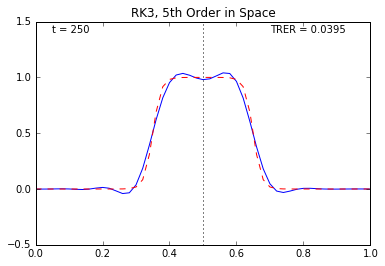

In [58]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.5, 1.5))
plt.title('RK3, 5th Order in Space')
line, = ax.plot([], [], lw=1)
line2, = ax.plot([], [], lw=1,ls='dashed',color='r')
time_template = 't = %.0f'
time_text = ax.text(0.05, 1.4, '')
ax.axvline(0.5,ls='dotted',color='k')
plt.text(0.7,1.4,'TRER = '+str(np.round(TRER,decimals=4)))
x2 = x

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    time_text.set_text('')
    return line, line2, time_text

# animation function.  This is called sequentially
def animate(i):
    #x = np.linspace(0, 2, 1000)
    #y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, qc5[i,:])
    line2.set_data(x, exact_f[i,:])
    time_text.set_text(time_template % (i))
    return line, line2, time_text

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=251, interval=20, blit=True)

# call our new function to display the animation
#display_animation(anim)

# To same animation, comment out previous line and
# uncomment the next two lines.
fname = 'rk3_time_5th_order_space_box.mp4'
anim.save(fname, fps=20,dpi=500)

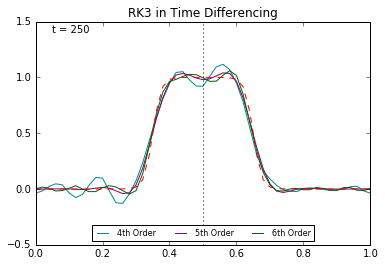

In [57]:
%matplotlib inline
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.5, 1.5))
plt.title('RK3 in Time Differencing')
#line, = ax.plot([], [], lw=1, label='Upstream')
line4, = ax.plot([], [], lw=1, c='darkcyan', label='4th Order')
line5, = ax.plot([], [], lw=1, c='purple', label='5th Order')
line6, = ax.plot([], [], lw=1, c='darkgreen', label='6th Order')
line_ex, = ax.plot([], [], lw=1,ls='dashed',color='r')
time_template = 't = %.0f'
time_text = ax.text(0.05, 1.4, '')
ax.axvline(0.5,ls='dotted',color='k')
ax.legend(handles=[line4,line5,line6],loc='lower center',fontsize=8,ncol=4)
x2 = x

# initialization function: plot the background of each frame
def init():
    #line.set_data([], [])
    line4.set_data([], [])
    line5.set_data([], [])
    line6.set_data([], [])
    line_ex.set_data([], [])
    time_text.set_text('')
    return line4, line5, line6, line_ex, time_text

# animation function.  This is called sequentially
def animate(i):
    #x = np.linspace(0, 2, 1000)
    #y = np.sin(2 * np.pi * (x - 0.01 * i))
    #line.set_data(x, q[i,:])
    line4.set_data(x, qc4[i,:])
    line5.set_data(x, qc5[i,:])
    line6.set_data(x, qc6[i,:])
    line_ex.set_data(x, exact_f[i,:])
    time_text.set_text(time_template % (i))
    return line4, line5, line6, line_ex, time_text

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=251, interval=20, blit=True)

# call our new function to display the animation
#display_animation(anim)

# To same animation, comment out previous line and
# uncomment the next two lines.
fname = 'rk3_time_all_box.mp4'
anim.save(fname, fps=20,dpi=500)